Na (malinko změněném) [převzatém příkladu](http://nbviewer.ipython.org/github/cs109/content/blob/master/lec_04_wrangling.ipynb) si ukážeme, jako pomocí [Pandas](http://pandas.pydata.org/) spolu s [Matplotlib](http://matplotlib.org/) a [ggplot](https://github.com/yhat/ggplot/) analyzovat data. Pandas je z velké části inspirován R-kem, konkrétně `data.frame` třídou, která se v Pandas nazývá `DataFrame`. Jedná se o 2D tabulární strukturu, podobnou relační databázi (SQL) nebo tabulce Excelu. Pandas využívá NumPy pro většinu výpočtů, které jsou tím pádem velice rychlé, a zároveň umožňuje velice flexibilní manipulaci s daty.
<!-- TEASER_END -->

# Pandas

Materiály převzaty z: Companion to Lecture 4 of [Harvard CS109: Data Science](http://cs109.org) course.

In [1]:
# pokud nemáme knihovnu pandas, tak ji nainstalujeme
# !pip install pandas -U

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Máme připravený dataset s informacemi o top filmech dle [IMDB](http://www.imdb.com/). Soubor imdb_top_10000.txt)

In [3]:
# prvních několik řádků
!head imdb_top_10000.txt

'head' is not recognized as an internal or external command,
operable program or batch file.


## 1. Sestavte DataFrame

Textový soubor je oddělen tabulátory a nemá žádná záhlaví sloupců. Nastavíme příslušná klíčová slova v `pd.read_csv`, aby se dataset bez problému načetl.

In [4]:
names = ['imdbID', 'title', 'year', 'score', 'votes', 'runtime', 'genres']
data = pd.read_csv('imdb_top_10000.txt', delimiter='\t', names=names).dropna()
print("Number of rows: %i" % data.shape[0])
data.head()  # print the first 5 rows

Number of rows: 9999


,imdbID,title,year,score,votes,runtime,genres
0,tt0111161,The Shawshank Redemption (1994),1994,9.2,619479,142 mins.,Crime|Drama
1,tt0110912,Pulp Fiction (1994),1994,9.0,490065,154 mins.,Crime|Thriller
2,tt0137523,Fight Club (1999),1999,8.8,458173,139 mins.,Drama|Mystery|Thriller
3,tt0133093,The Matrix (1999),1999,8.7,448114,136 mins.,Action|Adventure|Sci-Fi
4,tt1375666,Inception (2010),2010,8.9,385149,148 mins.,Action|Adventure|Sci-Fi|Thriller


Všimněte si pěkného html formátování výsledného DataFrame.

## 2. Vyčistěte DataFrame

V tomto okamžiku existuje několik problémů s DataFrame:

1. Sloupec runtime popisuje číslo, ale je uložen jako řetězec
2. Sloupec žánry není atomický – sdružuje několik žánrů dohromady. To ztěžuje například extrahování filmů, které jsou komedie.
3. Rok filmu se opakuje ve sloupci název a rok

### Oprava sloupce runtime

Následující úryvek převede řetězec jako '142 minut.' na číslo 142:

In [5]:
dirty = '142 mins.'
number, text = dirty.split(' ')
clean = int(number)
print(number)

142


Můžeme to udělat najednou pro všechny záznamy pomocí list comprehension

In [6]:
clean_runtime = [float(r.split(' ')[0]) for r in data.runtime]
data['runtime'] = clean_runtime
data.head()

,imdbID,title,year,score,votes,runtime,genres
0,tt0111161,The Shawshank Redemption (1994),1994,9.2,619479,142.0,Crime|Drama
1,tt0110912,Pulp Fiction (1994),1994,9.0,490065,154.0,Crime|Thriller
2,tt0137523,Fight Club (1999),1999,8.8,458173,139.0,Drama|Mystery|Thriller
3,tt0133093,The Matrix (1999),1999,8.7,448114,136.0,Action|Adventure|Sci-Fi
4,tt1375666,Inception (2010),2010,8.9,385149,148.0,Action|Adventure|Sci-Fi|Thriller


### Rozdělení žánrů
Můžeme použít koncept *indicator variables* k rozdělení sloupce žánry do mnoha sloupců. Každý nový sloupec bude odpovídat jednomu žánru a každá buňka bude mít hodnotu True nebo False.

In [20]:
# vyrobíme seznam unikátních žánrů

genres = set()
for m in data.genres:
    genres.update(g for g in m.split('|'))
genres = sorted(genres)
print(genres)

['Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western']


In [21]:
# každý žánr přidáme jako nový sloupec do tabulky
for genre in genres:
    data[genre] = [genre in movie.split('|') for movie in data.genres]
         
data.head()

,imdbID,title,year,score,votes,runtime,genres,Action,Adult,Adventure,...,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Sport,Thriller,War,Western
0,tt0111161,The Shawshank Redemption,1994,9.2,619479,142.0,Crime|Drama,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,tt0110912,Pulp Fiction,1994,9.0,490065,154.0,Crime|Thriller,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,tt0137523,Fight Club,1999,8.8,458173,139.0,Drama|Mystery|Thriller,False,False,False,...,False,True,False,False,False,False,False,True,False,False
3,tt0133093,The Matrix,1999,8.7,448114,136.0,Action|Adventure|Sci-Fi,True,False,True,...,False,False,False,False,False,True,False,False,False,False
4,tt1375666,Inception,2010,8.9,385149,148.0,Action|Adventure|Sci-Fi|Thriller,True,False,True,...,False,False,False,False,False,True,False,True,False,False


### Odebírání roku z názvu
Každý prvek můžeme opravit odstraněním posledních 7 znaků

In [22]:
data['title'] = [t[0:-7] for t in data.title]
data.head()

,imdbID,title,year,score,votes,runtime,genres,Action,Adult,Adventure,...,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Sport,Thriller,War,Western
0,tt0111161,The Shawshank Red,1994,9.2,619479,142.0,Crime|Drama,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,tt0110912,Pulp,1994,9.0,490065,154.0,Crime|Thriller,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,tt0137523,Fig,1999,8.8,458173,139.0,Drama|Mystery|Thriller,False,False,False,...,False,True,False,False,False,False,False,True,False,False
3,tt0133093,The,1999,8.7,448114,136.0,Action|Adventure|Sci-Fi,True,False,True,...,False,False,False,False,False,True,False,False,False,False
4,tt1375666,In,2010,8.9,385149,148.0,Action|Adventure|Sci-Fi|Thriller,True,False,True,...,False,False,False,False,False,True,False,True,False,False


## 3. Prozkoumejte globální vlastnosti

Dále se seznámíme s některými základními, globálními souhrny tabulky DataFrame.

### V příslušných sloupcích zavolejte `describe`.

In [23]:
data[['score', 'runtime', 'year', 'votes']].describe(include='all')

,score,runtime,year,votes
count,9999.000000,9717.000000,9999.000000,9999.000000
mean,6.385989,106.586395,1993.471447,16605.462946
std,1.189965,20.230330,14.830049,34564.883945
min,1.500000,45.000000,1950.000000,1356.000000
25%,5.700000,93.000000,1986.000000,2334.500000
50%,6.600000,103.000000,1998.000000,4981.000000
75%,7.200000,115.000000,2005.000000,15278.500000
max,9.200000,450.000000,2011.000000,619479.000000


In [24]:
# hmmm, a runtime = 0?!
print(len(data[data.runtime == 0]))


0


In [25]:
# lepší by bylo nahradit nulou za NaN, 0 smysl nedává, ať nás neplete
data.runtime[data.runtime==0] = np.nan

C:\Users\kater\AppData\Local\Temp/ipykernel_3288/4179875030.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.runtime[data.runtime==0] = np.nan


In [26]:
data.runtime.describe()

count    9717.000000
mean      106.586395
std        20.230330
min        45.000000
25%        93.000000
50%       103.000000
75%       115.000000
max       450.000000
Name: runtime, dtype: float64

### Make some basic plots

Text(0.5, 0, 'Release Year')

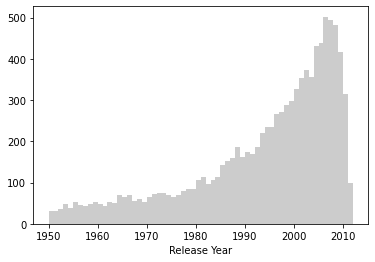

In [27]:
plt.hist(data.year, bins=np.arange(1950, 2013), color='#cccccc')
plt.xlabel("Release Year")

**Grafy pomocí [ggplot](https://github.com/yhat/ggplot/) balíčku. Pro uživatele R.**

In [30]:
# instalace pomocí knihovny plotnine
%pip install plotnine -U

  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.4
    Uninstalling pandas-1.3.4:
      Successfully uninstalled pandas-1.3.4
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.4.3
    Uninstalling matplotlib-3.4.3:


ERROR: Could not install packages due to an OSError: [WinError 32] Proces nemá přístup k souboru, neboť jej právě využívá jiný proces: 'c:\\users\\kater\\anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans-Oblique.ttf'
Consider using the `--user` option or check the permissions.



In [31]:
import plotnine as p9

ModuleNotFoundError: No module named 'plotnine'

In [17]:
p = p9.ggplot(data, p9.aes(x='year'))
p + p9.geom_histogram(binwidth=1) + p9.ggtitle("Movies per year histogram")


NameError: name 'p9' is not defined

Text(0.5, 0, 'IMDB rating')

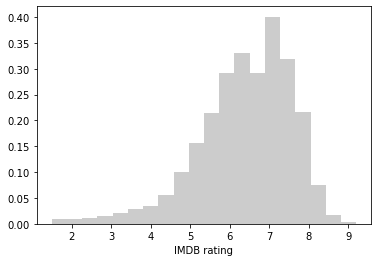

In [18]:
plt.hist(data.score, bins=20, color='#cccccc',density=True)
plt.xlabel("IMDB rating")

Text(0.5, 0, 'Runtime distribution')

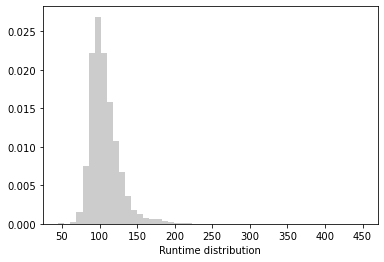

In [19]:
plt.hist(data.runtime.dropna(), bins=50, color='#cccccc',density=True)
plt.xlabel("Runtime distribution")

In [ ]:
#hmm, more bad, recent movies. Real, or a selection bias?

plt.scatter(data.year, data.score, lw=0, alpha=.08, color='k')
plt.xlabel("Year")
plt.ylabel("IMDB Rating")

In [ ]:
plt.scatter(data.votes, data.score, lw=0, alpha=.2, color='k')
plt.xlabel("Number of Votes")
plt.ylabel("IMDB Rating")
plt.xscale('log')

### Vybírání prvků dle podmínek

In [ ]:
# low-score movies with lots of votes
data[(data.votes > 9e4) & (data.score < 5)][['title', 'year', 'score', 'votes', 'genres']]

In [ ]:
# The lowest rated movies
data[data.score == data.score.min()][['title', 'year', 'score', 'votes', 'genres']]

In [ ]:
# The highest rated movies
data[data.score == data.score.max()][['title', 'year', 'score', 'votes', 'genres']]

### Spusťte agregační funkce jako `sum` na několika řádcích nebo sloupcích

*Jaké žánry jsou nejčastější?*

In [ ]:
#sum sums over rows by default
genre_count = np.sort(data[genres].sum())[::-1]
pd.DataFrame({'Genre': genres, 'Genre Count': genre_count})

*Kolik žánrů má film v průměru?*

In [ ]:
#axis=1 sums over columns instead
genre_count = data[genres].sum(axis=1) 
print(f"Average movie has {genre_count.mean()} genres")
genre_count.describe()

## Prozkoumejte vlastnosti skupin

Rozdělme filmy podle desetiletí

In [ ]:
decade =  (data.year // 10) * 10

tyd = data[['title', 'year']]
tyd['decade'] = decade

tyd.head()

[GroupBy](http://pandas.pydata.org/pandas-docs/dev/groupby.html) will gather movies into groups with equal decade values

In [ ]:
# mean score for all movies in each decade
decade_mean = data.groupby(decade).score.mean()
decade_mean.name = 'Decade Mean'
print(decade_mean)

In [ ]:
# vykreslíme si graf (předchozí scatter plot) s průměrem hodnocení za dekádu
plt.plot(decade_mean.index, decade_mean.values, 'o-',
        color='r', lw=3, label='Decade Average')
plt.scatter(data.year, data.score, alpha=.04, lw=0, color='k')
plt.xlabel("Year")
plt.ylabel("Score")
plt.legend(frameon=False)

Můžeme jít ještě dále a vypočítat rozptyl v každédekádě

In [ ]:
grouped_scores = data.groupby(decade).score

mean = grouped_scores.mean()
std = grouped_scores.std()
print(std)

In [ ]:
# a přikreslit tento udaj jako "fill" kolem průměru
plt.plot(decade_mean.index, decade_mean.values, 'o-',
        color='r', lw=3, label='Decade Average')
plt.fill_between(decade_mean.index, (decade_mean + std).values,
                 (decade_mean - std).values, color='r', alpha=.2)
plt.scatter(data.year, data.score, alpha=.04, lw=0, color='k')
plt.xlabel("Year")
plt.ylabel("Score")
plt.legend(frameon=False)

Objekt GroupBy můžete také iterovat. Každá iterace poskytuje dvě proměnné: jednu z odlišných hodnot skupinového klíče a podmnožinu datového rámce, kde se klíč rovná této hodnotě. Jak najít nejoblíbenější film každý rok:

In [ ]:
for year, subset in data.groupby('year'):
    print(year, subset[subset.score == subset.score.max()].title.values)

### Malé násobky

Rozdělme filmy podle žánru a podívejme se, jak se liší jejich rok vydání/doba spuštění/skóre IMDB.
Distribuce pro všechny filmy je zobrazena jako šedé pozadí.

Toto není standardní groupby, takže zde nemůžeme použít metodu `groupby`. Je potřeba ruční smyčka

In [ ]:
#create a 4x6 grid of plots.
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(12, 8), 
                         tight_layout=True)

bins = np.arange(1950, 2013, 3)
for ax, genre in zip(axes.ravel(), genres):
    ax.hist(data[data[genre] == 1].year, density=True,
            bins=bins, histtype='stepfilled', color='r', alpha=.3, ec='none')
    ax.hist(data.year, bins=bins, histtype='stepfilled', ec='None', density=True, zorder=0, color='#cccccc')
    
    ax.annotate(genre, xy=(1955, 3e-2), fontsize=14)
    ax.xaxis.set_ticks(np.arange(1950, 2013, 30))
    ax.set_yticks([])
    ax.set_xlabel('Year')

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(12, 8), tight_layout=True)

bins = np.arange(30, 240, 10)

for ax, genre in zip(axes.ravel(), genres):
    ax.hist(data[data[genre] == 1].runtime, density=True,
            bins=bins, histtype='stepfilled', color='r', ec='none', alpha=.3)
               
    ax.hist(data.runtime, bins=bins, density=True,
            histtype='stepfilled', ec='none', color='#cccccc',
            zorder=0)
    
    ax.set_xticks(np.arange(30, 240, 60))
    ax.set_yticks([])
    ax.set_xlabel("Runtime [min]")
    ax.annotate(genre, xy=(230, .02), ha='right', fontsize=12)

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(12, 8), tight_layout=True)

bins = np.arange(0, 10, .5)

for ax, genre in zip(axes.ravel(), genres):
    ax.hist(data[data[genre] == 1].score, density=True,
            bins=bins, histtype='stepfilled', color='r', ec='none', alpha=.3)
               
    ax.hist(data.score, bins=bins,
            histtype='stepfilled', ec='none', color='#cccccc', density=True,
            zorder=0)
    
    ax.set_yticks([])
    ax.set_xlabel("Score")
    ax.annotate(genre, xy=(0, .2), ha='left', fontsize=12)

## Other Resources

* Chapters 5 and 7 of [Python for Data Analysis](http://www.amazon.com/Python-Data-Analysis-Wes-McKinney/dp/1449319793)
* Jupyter Notebook on [Data wrangling with Pandas](http://nbviewer.ipython.org/urls/gist.github.com/fonnesbeck/5850413/raw/3a9406c73365480bc58d5e75bc80f7962243ba17/2.+Data+Wrangling+with+Pandas.ipynb)
* [Lecture 4](https://drive.google.com/folderview?id=0BxYkKyLxfsNVd0xicUVDS1dIS0k&usp=sharing) of Harvard's CS 109: Data Science